# Sequence Tagging (Named Entity Recognition)
# Advanced Example: Bi-Directional LSTM + CRF


## Accuracy f1 dev:
* Epoch 0: 0.5073 %
* Epoch 10: 0.8664 %
* Epoch 30: 0.9154 %


## Used Tools:

* Tensorflow
* Keras
* GloVe (Word Embedding)

## Source:
[Sequence Tagging with Tensorflow by Guillaume Genthial](https://guillaumegenthial.github.io/sequence-tagging-with-tensorflow.html)

## Full Model:

<img src="screens/model.png" alt="graph" width="600"/>

In [6]:
# install keras if necessary
# !pip install -q keras

## Load packages
* numpy
* keras
* validation.py (helper class)
* prepro.py (helper class)
* tensorflow

In [7]:
import numpy as np
import tensorflow as tf
import urllib
import urllib.request
import os
import zipfile

from validation import compute_f1
from keras.models import Model, load_model
from keras.layers import TimeDistributed, Conv1D, Dense, Embedding, Input, Dropout, LSTM, Bidirectional, MaxPooling1D, \
    Flatten, concatenate
from prepro import readfile, createBatches, createMatrices, iterate_minibatches, addCharInformation, padding
from keras.utils import plot_model
from keras.initializers import RandomUniform
from keras.optimizers import SGD, Nadam
from keras.callbacks import TensorBoard

## Parameters:
* EPOCHS = 30 (Number of times the training data gets iterated through)
* DROPOUT= 0.5 (Probability for a normal neuron to be dropped at one iteration)
* DROPOUT_RECURRENT = 0.25 (Probability for a reccurent neuron to be dropped at one iteration)
* LSTM_STATE_SIZE = 200 (Size of LSTM)
* CONV_SIZE = 3 (Size of convolutional network)
* LEARNING RATE = 0.0105 (Learning rate at start, decreases at time)
* OPTIMIZER = Nadam() ([Recommended] Nesterov Adam optimizer: Adam optimizer with Nestrov momentum)

In [8]:
# Define parameters
EPOCHS = 30
DROPOUT = 0.5 
DROPOUT_RECURRENT = 0.25
LSTM_STATE_SIZE = 200 
CONV_SIZE = 3   
LEARNING_RATE = 0.0105
OPTIMIZER = Nadam()

## Open word embedding GloVe to respresent words as global vectors


### Download and extract GloVe

In [9]:
# Check if Glove 100d txt embedding is in embeddings folder
if(not (os.path.isfile("../embeddings/glove.6B.100d.txt"))):
    # Check if Glove zip is in embeddings folder
    if(not (os.path.isfile("../embeddings/glove.6B.zip"))):
        dlurl='http://nlp.stanford.edu/data/glove.6B.zip'
        print("Downloading GloVe...")
        urllib.request.urlretrieve (dlurl, "../embeddings/glove.6B.zip")
    
    # Extract embedding
    with zipfile.ZipFile("../embeddings/glove.6B.zip") as myzip:
        print("Extracting GloVe...")
        myzip.extract('glove.6B.100d.txt', '../embeddings')

### Open GloVe

In [10]:
fEmbeddings = open("../embeddings/glove.6B.100d.txt", encoding="utf-8")

## Main Class

### 1. Word level representation from characters embeddings
<img src="screens/char_representation.png" alt="graph" width="400"/>

### 2. Bidirectional LSTM on top of word representation to extract contextual representation of each word
<img src="screens/bi-lstm.png" alt="graph" width="400"/>


In [11]:
"""Initialise class"""

class CNN_BLSTM(object):
    
    def __init__(self, EPOCHS, DROPOUT, DROPOUT_RECURRENT, LSTM_STATE_SIZE, CONV_SIZE, LEARNING_RATE, OPTIMIZER):
        
        # Set parameters
        self.epochs = EPOCHS
        self.dropout = DROPOUT
        self.dropout_recurrent = DROPOUT_RECURRENT
        self.lstm_state_size = LSTM_STATE_SIZE
        self.conv_size = CONV_SIZE
        self.learning_rate = LEARNING_RATE
        self.optimizer = OPTIMIZER
        
    def loadData(self):
      
        # Use the readfile() method of prepro.py to load the data and add character information
        self.trainSentences = readfile("../data/train.txt")
        self.devSentences = readfile("../data/dev.txt")
        self.testSentences = readfile("../data/test.txt")

    def addCharInfo(self):
      
        # Use the addCharInformation() method of prepro.py to format the data to: [['the', ['t', 'h', 'e'], 'O\n']['EU', ['E', 'U'], 'B-ORG\n'], ...]
        self.trainSentences = addCharInformation(self.trainSentences)
        self.devSentences = addCharInformation(self.devSentences)
        self.testSentences = addCharInformation(self.testSentences)

    def embed(self):
        """Create word- and character-level embeddings"""

        labelSet = set()
        words = {}

        # Add unique words and labels of all data files to literals
        for dataset in [self.trainSentences, self.devSentences, self.testSentences]:
            for sentence in dataset:
                for token, char, label in sentence:   
                    labelSet.add(label)
                    words[token.lower()] = True

        # Map labels
        self.label2Idx = {}
        for label in labelSet:
            self.label2Idx[label] = len(self.label2Idx)

        # Map token cases
        # PADDING_TOKEN: pad sentences to make them the same length
        case2Idx = {'numeric': 0, 'allLower': 1, 'allUpper': 2, 'initialUpper': 3, 'other': 4, 'mainly_numeric': 5,
                    'contains_digit': 6, 'PADDING_TOKEN': 7}
        self.caseEmbeddings = np.identity(len(case2Idx), dtype='float32')  # identity matrix used 

        # Read GLoVE word embeddings
        word2Idx = {}
        self.wordEmbeddings = []

        

        # Loop through words in embeddings
        for line in fEmbeddings:
            split = line.strip().split(" ")
            word = split[0]  # embedding word entry

            if len(word2Idx) == 0:  # add padding+unknown
                word2Idx["PADDING_TOKEN"] = len(word2Idx)
                vector = np.zeros(len(split) - 1)  # zero vector for 'PADDING' word
                self.wordEmbeddings.append(vector)

                word2Idx["UNKNOWN_TOKEN"] = len(word2Idx)
                vector = np.random.uniform(-0.25, 0.25, len(split) - 1)
                self.wordEmbeddings.append(vector)

            if split[0].lower() in words:
                vector = np.array([float(num) for num in split[1:]])
                self.wordEmbeddings.append(vector)  # word embedding vector
                word2Idx[split[0]] = len(word2Idx)  # corresponding word dict

        self.wordEmbeddings = np.array(self.wordEmbeddings)
        
        # Create string with possible characters
        chars = " 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,-_()[]{}!?:;#'\"/\\%$`&=*+@^~|<>"

        # Create dictionary of possible characters
        self.char2Idx = {"PADDING": 0, "UNKNOWN": 1}
        for c in chars:
            self.char2Idx[c] = len(self.char2Idx)

        # Use padding() and createMatrices() methods from prepro.py to format the data to: [[wordindices], [caseindices], [padded word indices], [label indices]]
        # Create train set
        self.train_set = padding(createMatrices(self.trainSentences, word2Idx, self.label2Idx, case2Idx, self.char2Idx))
        # Create dev set
        self.dev_set = padding(createMatrices(self.devSentences, word2Idx, self.label2Idx, case2Idx, self.char2Idx))
        # Create test set
        self.test_set = padding(createMatrices(self.testSentences, word2Idx, self.label2Idx, case2Idx, self.char2Idx))

        self.idx2Label = {v: k for k, v in self.label2Idx.items()}
        
    def createBatches(self):
        """Create batches with createBatches() method in prepro.py"""
        
        # Create train batch
        self.train_batch, self.train_batch_len = createBatches(self.train_set)
        # Create dev batch
        self.dev_batch, self.dev_batch_len = createBatches(self.dev_set)
        # Create test batch
        self.test_batch, self.test_batch_len = createBatches(self.test_set)
        
    def tag_dataset(self, dataset, model):
        """Tag data with numerical values"""
        
        correctLabels = []
        predLabels = []
        
        for i, data in enumerate(dataset):
            tokens, casing, char, labels = data
            tokens = np.asarray([tokens])
            casing = np.asarray([casing])
            char = np.asarray([char])
            pred = model.predict([tokens, casing, char], verbose=False)[0]
            pred = pred.argmax(axis=-1)  # Predict the classes
            correctLabels.append(labels)
            predLabels.append(pred)
            
        return predLabels, correctLabels
    
    def buildModel(self):
        """Model layers"""

        # Character input
        character_input = Input(shape=(None, 52,), name="Character_input")
        embed_char_out = TimeDistributed(
            Embedding(len(self.char2Idx), 30, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name="Character_embedding")(
            character_input)

        dropout = Dropout(self.dropout)(embed_char_out)

        # Convolutional Neural Network
        # TimeDistributed(): add additional time dimention
        conv1d_out = TimeDistributed(Conv1D(kernel_size=self.conv_size, filters=30, padding='same', activation='tanh', strides=1), name="Convolution")(dropout)
        maxpool_out = TimeDistributed(MaxPooling1D(52), name="Maxpool")(conv1d_out)
        char = TimeDistributed(Flatten(), name="Flatten")(maxpool_out)
        char = Dropout(self.dropout)(char)

        # Word-level input
        words_input = Input(shape=(None,), dtype='int32', name='words_input')
        words = Embedding(input_dim=self.wordEmbeddings.shape[0], output_dim=self.wordEmbeddings.shape[1], weights=[self.wordEmbeddings],
                          trainable=False)(words_input)

        # Case-info input
        casing_input = Input(shape=(None,), dtype='int32', name='casing_input')
        casing = Embedding(output_dim=self.caseEmbeddings.shape[1], input_dim=self.caseEmbeddings.shape[0], weights=[self.caseEmbeddings],
                           trainable=False)(casing_input)

        # Concat & bi-LSTM
        output = concatenate([words, casing, char])
        output = Bidirectional(LSTM(self.lstm_state_size, 
                                    return_sequences=True, 
                                    dropout=self.dropout,                        # on input to each LSTM block
                                    recurrent_dropout=self.dropout_recurrent     # on recurrent input signal
                                   ), name="BLSTM")(output)
        output = TimeDistributed(Dense(len(self.label2Idx), activation='softmax'),name="Softmax_layer")(output)

        # Set up model
        self.model = Model(inputs=[words_input, casing_input, character_input], outputs=[output])
        
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=self.optimizer)
        
        self.init_weights = self.model.get_weights()
        
    def train(self):
        """Default training"""
        
        # For plotting the learning curve
        self.f1_test_history = []
        self.f1_dev_history = []

        # Run through defined epochs
        for epoch in range(self.epochs):    
            print("Epoch {}/{}".format(epoch, self.epochs))
            for i,batch in enumerate(iterate_minibatches(self.train_batch,self.train_batch_len)):
                labels, tokens, casing,char = batch       
                self.model.train_on_batch([tokens, casing,char], labels)

            # Compute test F1 scores
            predLabels, correctLabels = self.tag_dataset(self.test_batch, self.model)
            pre_test, rec_test, f1_test = compute_f1(predLabels, correctLabels, self.idx2Label)
            self.f1_test_history.append(f1_test)
            print("   f1 test ", round(f1_test, 4))
            
            # Compute dev F1 scrores
            predLabels, correctLabels = self.tag_dataset(self.dev_batch, self.model)
            pre_dev, rec_dev, f1_dev = compute_f1(predLabels, correctLabels, self.idx2Label)
            self.f1_dev_history.append(f1_test)
            print("   f1 dev ", round(f1_dev, 4), "\n")
            
        print("Final F1 test score: ", f1_test)
            
        print("Training finished.")

    print("Class initialised.")

Class initialised.


## Run model

In [12]:
# Tensorboard setup
tensorboard = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
# Create class
cnn_blstm = CNN_BLSTM(EPOCHS, DROPOUT, DROPOUT_RECURRENT, LSTM_STATE_SIZE, CONV_SIZE, LEARNING_RATE, OPTIMIZER)
# Load data
cnn_blstm.loadData()
# Add character information
cnn_blstm.addCharInfo()
# Create word and character embeddings
cnn_blstm.embed()
# Create batches
cnn_blstm.createBatches()
# Build network model
cnn_blstm.buildModel()
# Start training
cnn_blstm.train()

Epoch 0/30
   f1 test  0.4474
   f1 dev  0.4828 

Epoch 1/30
   f1 test  0.6731
   f1 dev  0.7111 

Epoch 2/30
   f1 test  0.6486
   f1 dev  0.689 

Epoch 3/30
   f1 test  0.7668
   f1 dev  0.8061 

Epoch 4/30
   f1 test  0.7981
   f1 dev  0.8208 

Epoch 5/30
   f1 test  0.7987
   f1 dev  0.8232 

Epoch 6/30
   f1 test  0.8199
   f1 dev  0.8353 

Epoch 7/30
   f1 test  0.8343
   f1 dev  0.8506 

Epoch 8/30
   f1 test  0.8323
   f1 dev  0.8474 

Epoch 9/30
   f1 test  0.8339
   f1 dev  0.8604 

Epoch 10/30
   f1 test  0.8556
   f1 dev  0.8713 

Epoch 11/30
   f1 test  0.8471
   f1 dev  0.8683 

Epoch 12/30
   f1 test  0.8597
   f1 dev  0.8859 

Epoch 13/30
   f1 test  0.8658
   f1 dev  0.8825 

Epoch 14/30
   f1 test  0.8691
   f1 dev  0.8945 

Epoch 15/30
   f1 test  0.8662
   f1 dev  0.8879 

Epoch 16/30
   f1 test  0.8688
   f1 dev  0.8954 

Epoch 17/30
   f1 test  0.8742
   f1 dev  0.9012 

Epoch 18/30
   f1 test  0.8752
   f1 dev  0.9049 

Epoch 19/30
   f1 test  0.8803
   f1 dev  

# Plot learning curve (Optional)

In [13]:
import matplotlib.pyplot as plt

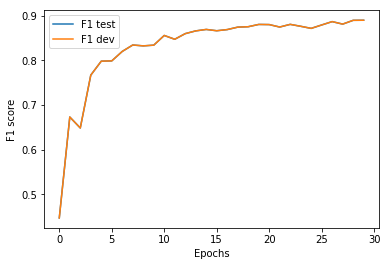

In [14]:
plt.plot(cnn_blstm.f1_test_history, label = "F1 test")
plt.plot(cnn_blstm.f1_dev_history, label = "F1 dev")
plt.xlabel("Epochs")
plt.ylabel("F1 score")
plt.legend()
plt.show()

# Label distribution (Optional)

In [15]:
cnn_blstm = CNN_BLSTM(EPOCHS, DROPOUT, DROPOUT_RECURRENT, LSTM_STATE_SIZE, CONV_SIZE, LEARNING_RATE, OPTIMIZER)
cnn_blstm.loadData()

category_count = {"B-ORG\n": 0, "I-ORG\n":0, "B-MISC\n": 0, "I-MISC\n":0, "B-LOC\n": 0, "I-LOC\n": 0, "B-PER\n": 0, "I-PER\n": 0, "O\n": 0}
total_count = 0

for sentence in cnn_blstm.trainSentences:
    for word in sentence:
        if word[1] in category_count.keys():
            category_count[word[1]] += 1
            total_count += 1

for category, count in category_count.items():
    print("{}: {}%".format(category.replace("\n", ""), round((count/total_count)*100, 2)))            

B-ORG: 3.1%
I-ORG: 1.82%
B-MISC: 1.69%
I-MISC: 0.57%
B-LOC: 3.51%
I-LOC: 0.57%
B-PER: 3.24%
I-PER: 2.22%
O: 83.28%
